<a href="https://colab.research.google.com/github/CHK-Ani/MalewareDetection/blob/main/MalewareDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train_path = "/content/drive/MyDrive/train.csv"

# Data Understanding & Cleaning

Load Data in Chunks (Memory-Safe Sampling)

In [ ]:
# Load data in chunks and take a 10% sample from each chunk
chunksize = 400_000  # safe chunk size for Colab
samples = []

# Read the CSV file piece by piece
for chunk in pd.read_csv(train_path, chunksize=chunksize, low_memory=False):
    # Take a 10% random sample from each chunk to build a smaller working dataset
    sample = chunk.sample(frac=0.10, random_state=42)
    samples.append(sample)

# Combine sampled chunks into one dataframe
df = pd.concat(samples, ignore_index=True)

# Show final dataset size
df.shape

(892148, 83)

Basic Data Inspection

In [ ]:
df.head()

# Check distribution of target classes
df['HasDetections'].value_counts(normalize=True)

# Unique value counts per column (helps identify high-cardinality features)
df.nunique().sort_values(ascending=False).head(20)

# Check column types and missing data counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892148 entries, 0 to 892147
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  892148 non-null  object 
 1   ProductName                                        892148 non-null  object 
 2   EngineVersion                                      892148 non-null  object 
 3   AppVersion                                         892148 non-null  object 
 4   AvSigVersion                                       892148 non-null  object 
 5   IsBeta                                             892148 non-null  int64  
 6   RtpStateBitfield                                   888971 non-null  float64
 7   IsSxsPassiveMode                                   892148 non-null  int64  
 8   DefaultBrowsersIdentifier                          43535 non-null   float6

Missing Data Analysis

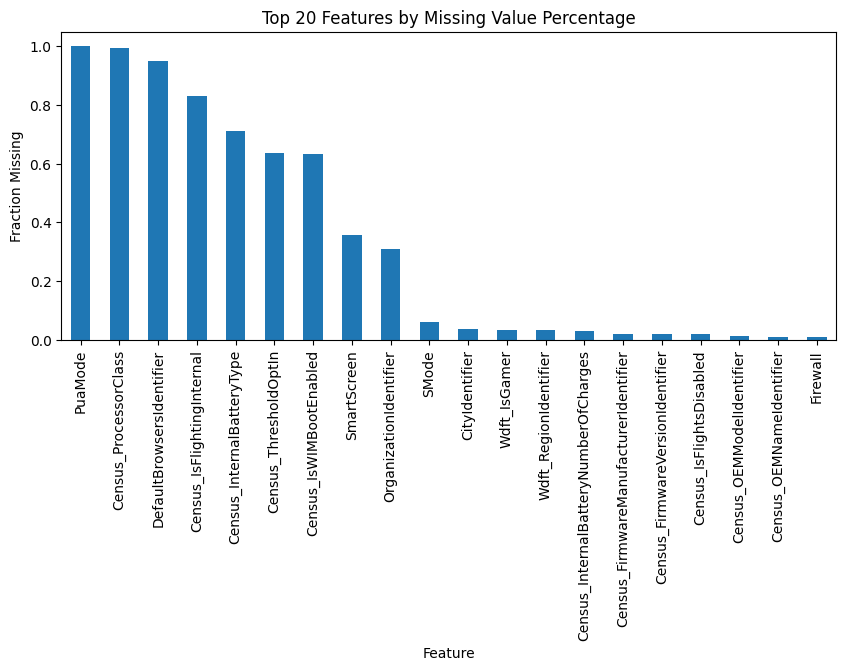

In [ ]:
# Calculate % missing values per column
missing = df.isna().mean().sort_values(ascending=False)

# Show the top 20 columns with the most missing values
missing.head(20)

# Visualize missing value percentages
missing.head(20).plot(kind='bar', figsize=(10,4))
plt.title("Top 20 Features by Missing Value Percentage")
plt.ylabel("Fraction Missing")
plt.xlabel("Feature")
plt.show()

Simple Numeric Outlier Inspection

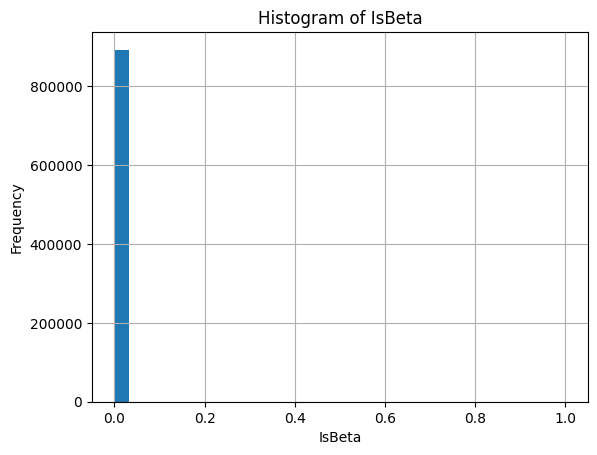

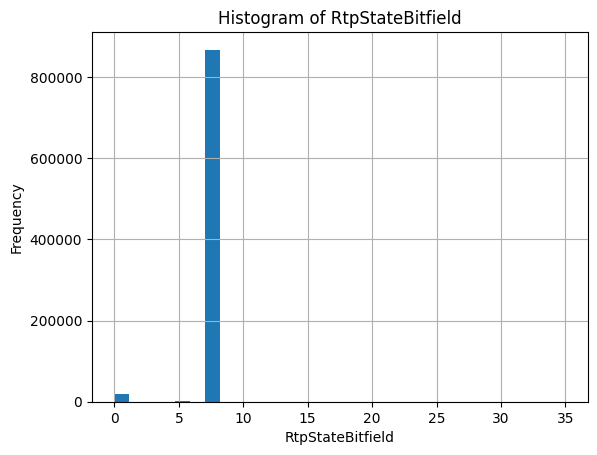

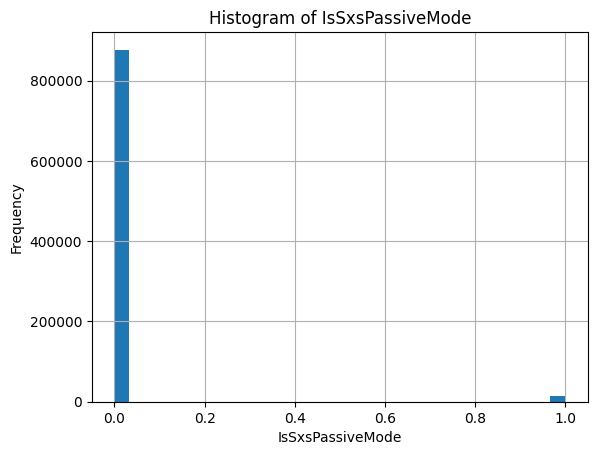

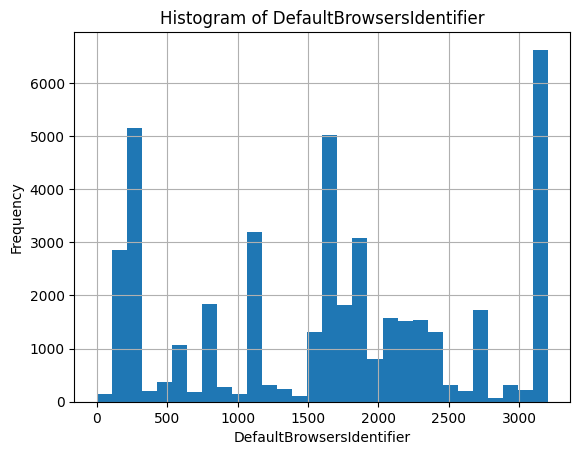

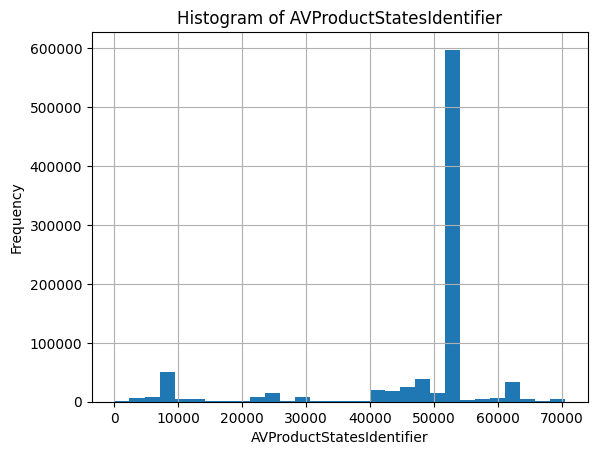

In [ ]:
# Inspect distributions for a small sample of numeric columns
# This helps decide whether to remove outliers or keep them.
num_cols_all = df.select_dtypes(include=['float64', 'int64']).columns

# Take up to the first 5 numeric features for quick inspection
num_cols_sample = list(num_cols_all[:5])

for col in num_cols_sample:
    df[col].hist(bins=30)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

Split Features/Target and Identify Types

In [ ]:
# Separate features (X) and target label (y)
target = "HasDetections"
X = df.drop(columns=[target])
y = df[target]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

num_cols, cat_cols[:10]

(Index(['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
        'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
        'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
        'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
        'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild',
        'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'IeVerIdentifier',
        'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier',
        'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount',
        'Census_ProcessorManufacturerIdentifier',
        'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
        'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive',
        'Census_TotalPhysicalRAM',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches',
        'Census_InternalPrimaryDisplayResolutionHorizontal',
        'Census_InternalPrimaryDisplayResolutionVertical',
        'Census_InternalBatteryNumberOfCh

In [ ]:
# ----------------------------------------------------
# Derived Features (Simple, Domain-Informed)
# ----------------------------------------------------

# 1. RAM per processor core
# Helps normalize RAM for device power differences
if ('Census_TotalPhysicalRAM' in num_cols) and ('Census_ProcessorCoreCount' in num_cols):
    X['RAM_per_core'] = X['Census_TotalPhysicalRAM'] / X['Census_ProcessorCoreCount']
else:
    X['RAM_per_core'] = np.nan  # fallback

# 2. Disk-to-RAM ratio
# Devices with low RAM but large disks may behave differently under load
if ('Census_PrimaryDiskTotalCapacity' in num_cols) and ('Census_TotalPhysicalRAM' in num_cols):
    X['disk_to_ram_ratio'] = X['Census_PrimaryDiskTotalCapacity'] / X['Census_TotalPhysicalRAM']
else:
    X['disk_to_ram_ratio'] = np.nan

# 3. OS Build "age"
# Higher OSBuild generally = newer OS / security patches
if 'OsBuild' in num_cols:
    X['OSBuild_age'] = X['OsBuild'].max() - X['OsBuild']
else:
    X['OSBuild_age'] = np.nan

# 4. Antivirus engine version major number
# Extracting the first component of EngineVersion (e.g. "1.1.15800" → 1)
if 'EngineVersion' in cat_cols:
    X['EngineVersion_major'] = df['EngineVersion'].astype(str).str.split('.', n=1).str[0]
else:
    X['EngineVersion_major'] = "Missing"

# Mark the new derived features as numeric or categorical
num_cols = list(num_cols) + ['RAM_per_core', 'disk_to_ram_ratio', 'OSBuild_age']
cat_cols = list(cat_cols) + ['EngineVersion_major']


Handle Missing Data (Imputation)

In [ ]:
# Numeric missing → fill with median (robust for skewed data)
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Categorical missing → add "Missing" category
X[cat_cols] = X[cat_cols].fillna("Missing")

Encode Categorical Features (Label Encoding)

In [ ]:
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()

    # Ensure training data has a consistent "Missing" category
    X[col] = X[col].astype(str).fillna("Missing")

    # Fit on training categories
    le.fit(X[col])

    # Guarantee "Missing" is part of the classes
    if "Missing" not in le.classes_:
        le.classes_ = np.append(le.classes_, "Missing")

    # Transform training data
    X[col] = le.transform(X[col])

    label_encoders[col] = le

In [ ]:
# Safety net: if any NaNs still remain (e.g., columns with all NaN), replace with -1
X = X.fillna(-1)

# Feature Engineering

Filter Method: Mutual Information Feature Selection

In [ ]:
# Compute mutual information between each feature and the target.
# Higher MI scores indicate stronger relationships with HasDetections.
mi_scores = mutual_info_classif(X, y, random_state=42)

# Wrap MI scores into a sorted Series for readability
mi = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Select the top 50 features by mutual information
top_50_mi = mi.head(50).index

# Display the top 20 MI scores
mi.head(20)


,0
IsProtected,0.130255
HasTpm,0.129059
Census_DeviceFamily,0.096178
AVProductsEnabled,0.094358
ProductName,0.090776
RtpStateBitfield,0.087846
Census_GenuineStateName,0.086477
Firewall,0.084192
DefaultBrowsersIdentifier,0.074320
Census_FlightRing,0.074005


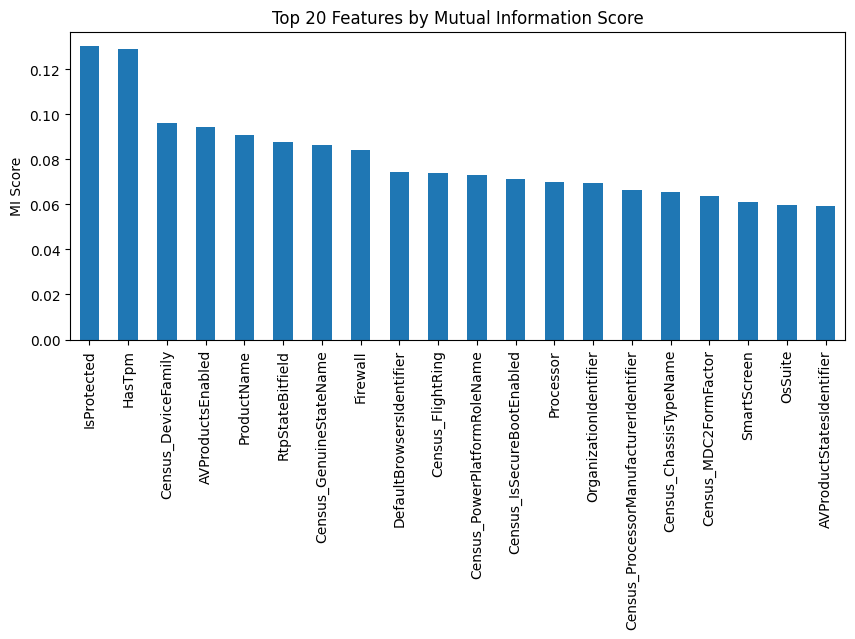

In [ ]:
# Plot the top 20 MI features for better understanding
mi.head(20).plot(kind='bar', figsize=(10,4))
plt.title("Top 20 Features by Mutual Information Score")
plt.ylabel("MI Score")
plt.show()

Embedded Method: Random Forest Feature Importances

In [ ]:
# Train a Random Forest on the top 50 MI features to estimate feature importance.
# This is an embedded feature selection method.
rf_fs = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

rf_fs.fit(X[top_50_mi], y)

# Extract and sort feature importances
importances = pd.Series(rf_fs.feature_importances_, index=top_50_mi).sort_values(ascending=False)

# Select the top 30 most important features
top_30_importances = importances.head(30).index

# Show the top 20 important features
importances.head(20)


,0
SmartScreen,0.289063
AVProductStatesIdentifier,0.094251
AVProductsInstalled,0.083605
EngineVersion,0.067970
AppVersion,0.033220
Census_InternalPrimaryDiagonalDisplaySizeInInches,0.032010
Census_PrimaryDiskTotalCapacity,0.027681
Census_TotalPhysicalRAM,0.025671
Census_OEMNameIdentifier,0.019551
Census_OSInstallTypeName,0.019257


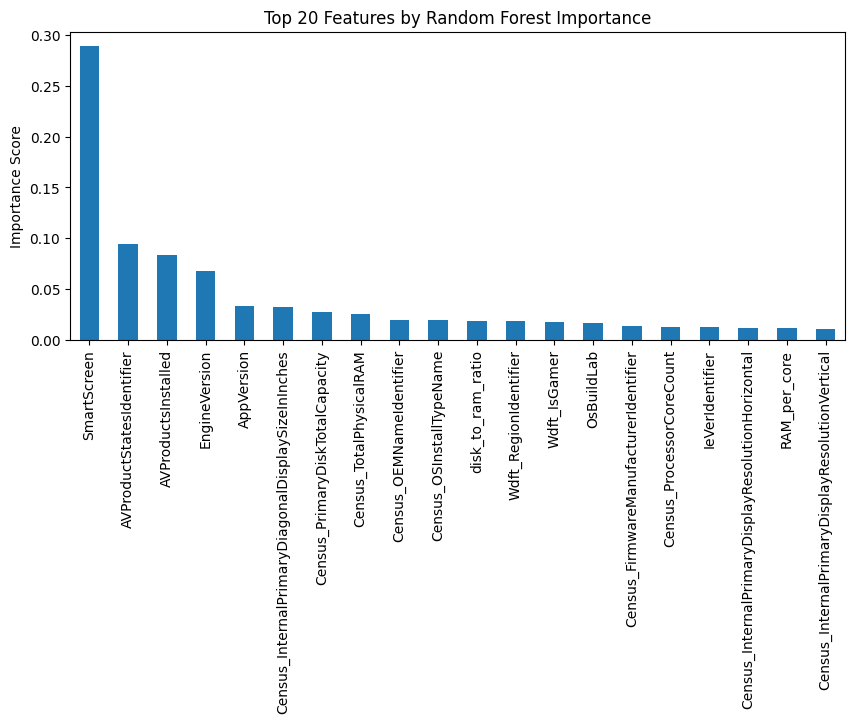

In [ ]:
# Plot top 20 important features from Random Forest
importances.head(20).plot(kind='bar', figsize=(10,4))
plt.title("Top 20 Features by Random Forest Importance")
plt.ylabel("Importance Score")
plt.show()

In [ ]:
# Final subset of features to use for modeling
selected_features = list(top_30_importances)
print("Total Selected Features:", len(selected_features))
selected_features

Total Selected Features: 30


['SmartScreen',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'EngineVersion',
 'AppVersion',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_PrimaryDiskTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_OEMNameIdentifier',
 'Census_OSInstallTypeName',
 'disk_to_ram_ratio',
 'Wdft_RegionIdentifier',
 'Wdft_IsGamer',
 'OsBuildLab',
 'Census_FirmwareManufacturerIdentifier',
 'Census_ProcessorCoreCount',
 'IeVerIdentifier',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'RAM_per_core',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Processor',
 'Census_ChassisTypeName',
 'Census_InternalBatteryNumberOfCharges',
 'Census_ActivationChannel',
 'RtpStateBitfield',
 'IsProtected',
 'Census_OSBranch',
 'Census_OSSkuName',
 'Census_OSEdition',
 'Census_PowerPlatformRoleName']

Train / Validation Split

In [ ]:
# Split the data into training and validation sets.
# Stratify on y to keep the same class balance in both sets.
X_train, X_val, y_train, y_val = train_test_split(
    X[selected_features],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Check resulting shapes
X_train.shape, X_val.shape

((713718, 30), (178430, 30))

# **Model Selection**

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def evaluate_model(model_name, y_true, y_pred, y_prob):
    print(f"\n=== {model_name} ===")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_true, y_prob):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_prob)
    plt.title(f"ROC Curve - {model_name}")
    plt.show()


**MODEL 1 — Decision Tree**


=== Decision Tree Classifier ===
Accuracy:  0.5692
Precision: 0.5688
Recall:    0.5650
F1 Score:  0.5669
ROC-AUC:   0.5704


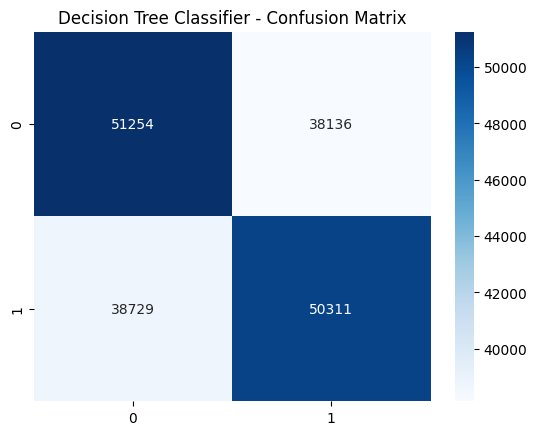

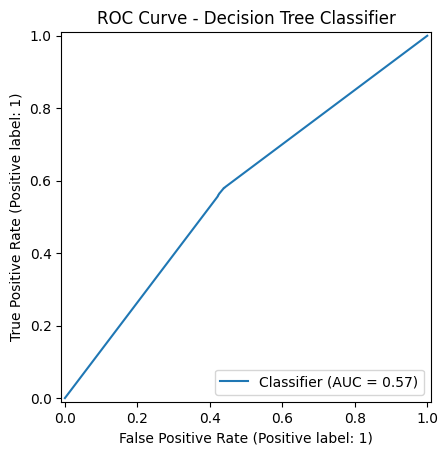

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions and probability predictions
y_pred_dt = dt_model.predict(X_val)
y_prob_dt = dt_model.predict_proba(X_val)[:, 1]

# Evaluate the model
evaluate_model("Decision Tree Classifier", y_val, y_pred_dt, y_prob_dt)

**MODEL 2 — XGBoost (L1 + L2 + Shrinkage + Sampling)**



=== XGBoost (L1 + L2 Regularized) ===
Accuracy:  0.6494
Precision: 0.6494
Recall:    0.6464
F1 Score:  0.6479
ROC-AUC:   0.7115


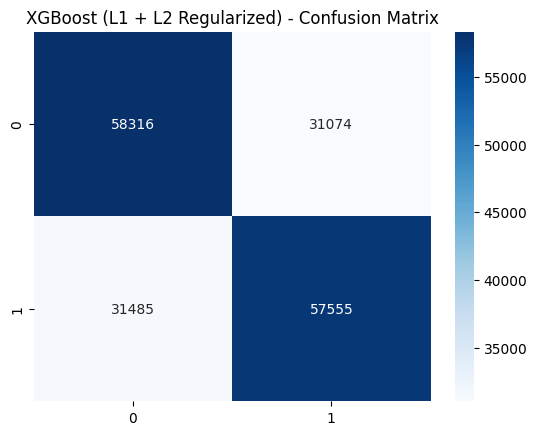

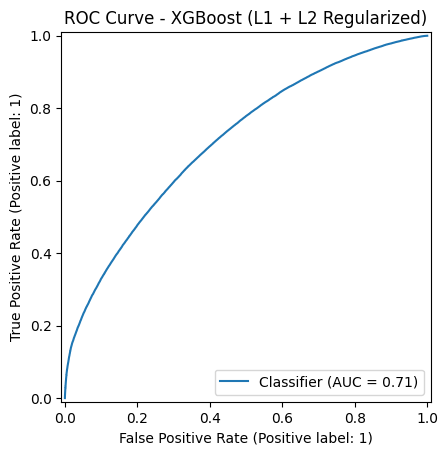

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.1,       # shrinkage
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # column sampling

    reg_lambda=1.0,          # L2
    reg_alpha=0.5,           # L1

    tree_method="hist",
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)
xgb_prob = xgb_model.predict_proba(X_val)[:,1]

evaluate_model("XGBoost (L1 + L2 Regularized)", y_val, xgb_pred, xgb_prob)


**MODEL 3 — LightGBM (L1 + L2 + Sampling Regularization)**

[LightGBM] [Info] Number of positive: 356158, number of negative: 357560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2404
[LightGBM] [Info] Number of data points in the train set: 713718, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499018 -> initscore=-0.003929
[LightGBM] [Info] Start training from score -0.003929

=== LightGBM (L1 + L2 Regularized) ===
Accuracy:  0.6490
Precision: 0.6505
Recall:    0.6412
F1 Score:  0.6458
ROC-AUC:   0.7105


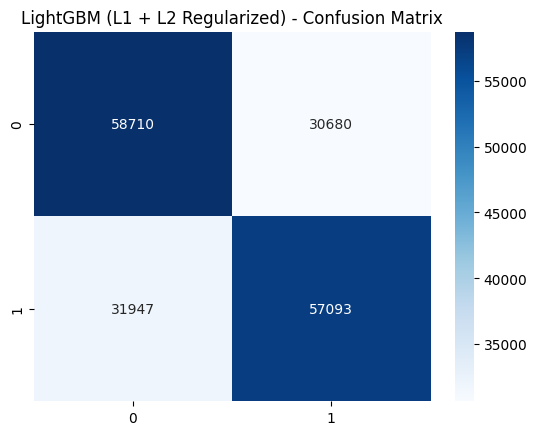

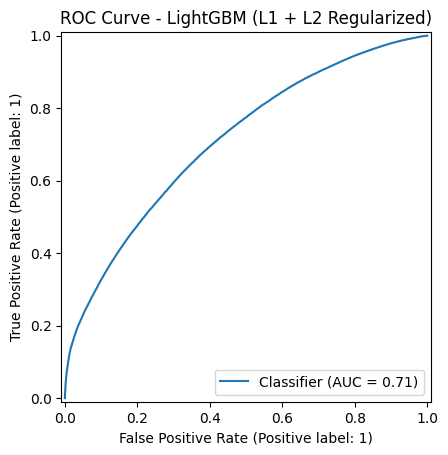

In [ ]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,             # regularization
    min_child_weight=40,       # regularization
    reg_lambda=1.0,            # L2
    reg_alpha=0.5,             # L1
    subsample=0.8,             # row sampling
    colsample_bytree=0.8,      # feature sampling
    random_state=42
)

lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_val)
lgb_prob = lgb_model.predict_proba(X_val)[:,1]

evaluate_model("LightGBM (L1 + L2 Regularized)", y_val, lgb_pred, lgb_prob)


**Model 4 - Random Forest (Bagging + Depth Regularization)**


=== Random Forest (Regularized) ===
Accuracy:  0.6443
Precision: 0.6432
Recall:    0.6452
F1 Score:  0.6442
ROC-AUC:   0.7057


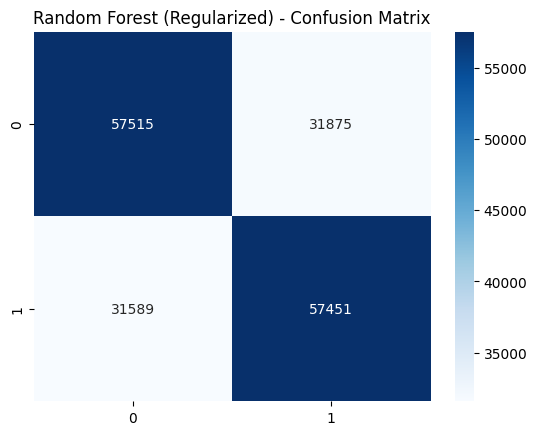

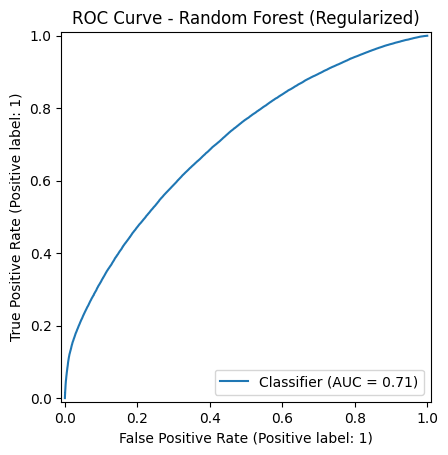

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=18,           # regularization
    min_samples_leaf=20,    # regularization
    min_samples_split=50,   # regularization
    max_features="sqrt",    # regularization (feature sampling)
    bootstrap=True,         # ensemble method
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_val)
rf_prob = rf_model.predict_proba(X_val)[:,1]

evaluate_model("Random Forest (Regularized)", y_val, rf_pred, rf_prob)


Collecting Results Into a List

In [ ]:
# Store model results
model_results = []

def add_results(name, y_true, y_pred, y_prob):
    model_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    })

# Add each model's results
add_results("Decision Tree", y_val, y_pred_dt, y_prob_dt)
add_results("XGBoost", y_val, xgb_pred, xgb_prob)
add_results("LightGBM", y_val, lgb_pred, lgb_prob)
add_results("Random Forest", y_val, rf_pred, rf_prob)


Creation of a Results DataFrame

In [ ]:
results_df = pd.DataFrame(model_results)
results_df


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Decision Tree,0.569215,0.568827,0.565038,0.566926,0.570363
1,XGBoost,0.649392,0.649392,0.646395,0.647890,0.711531
2,LightGBM,0.649011,0.650462,0.641206,0.645801,0.710470
3,Random Forest,0.644320,0.643161,0.645227,0.644192,0.705662


Bar Chart Comparing Metrics Across Models

<Figure size 1200x600 with 0 Axes>

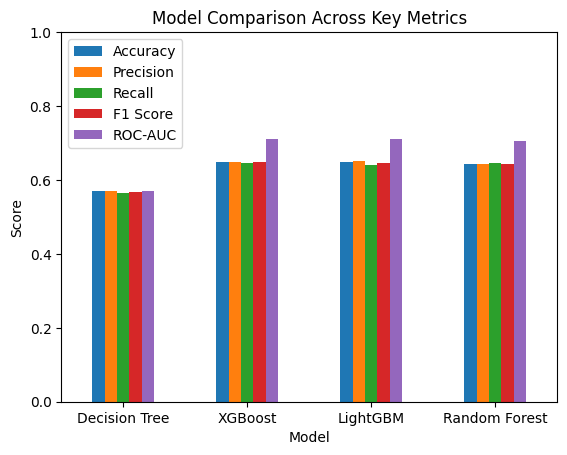

In [ ]:
plt.figure(figsize=(12,6))
results_df.set_index("Model")[["Accuracy","Precision","Recall","F1 Score","ROC-AUC"]].plot(kind="bar")
plt.title("Model Comparison Across Key Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()

Multiple ROC Curves on One Plot

<Figure size 1000x700 with 0 Axes>

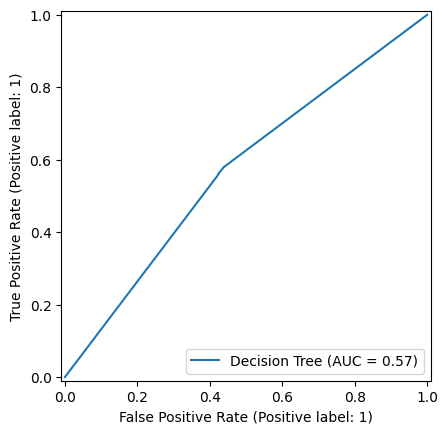

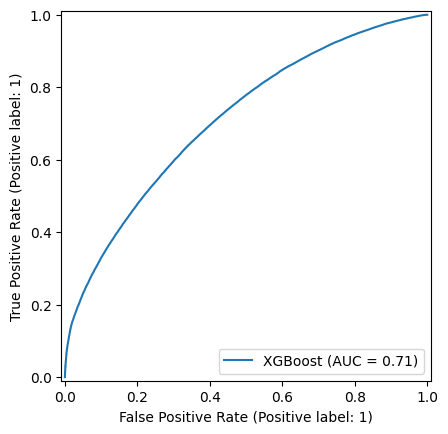

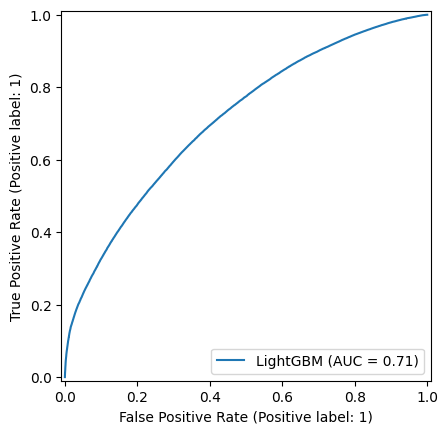

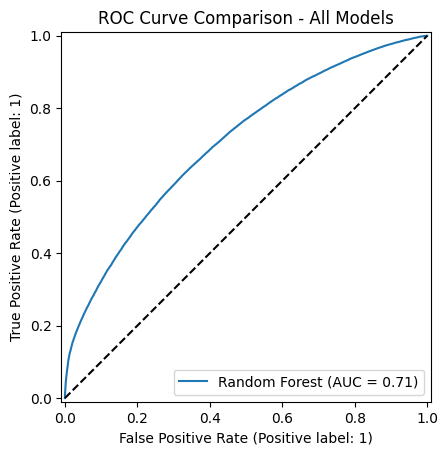

In [ ]:
plt.figure(figsize=(10,7))

RocCurveDisplay.from_predictions(y_val, y_prob_dt, name="Decision Tree")
RocCurveDisplay.from_predictions(y_val, xgb_prob, name="XGBoost")
RocCurveDisplay.from_predictions(y_val, lgb_prob, name="LightGBM")
RocCurveDisplay.from_predictions(y_val, rf_prob, name="Random Forest")

plt.title("ROC Curve Comparison - All Models")
plt.plot([0,1], [0,1], "k--")
plt.show()


2×2 Grid of Confusion Matrices

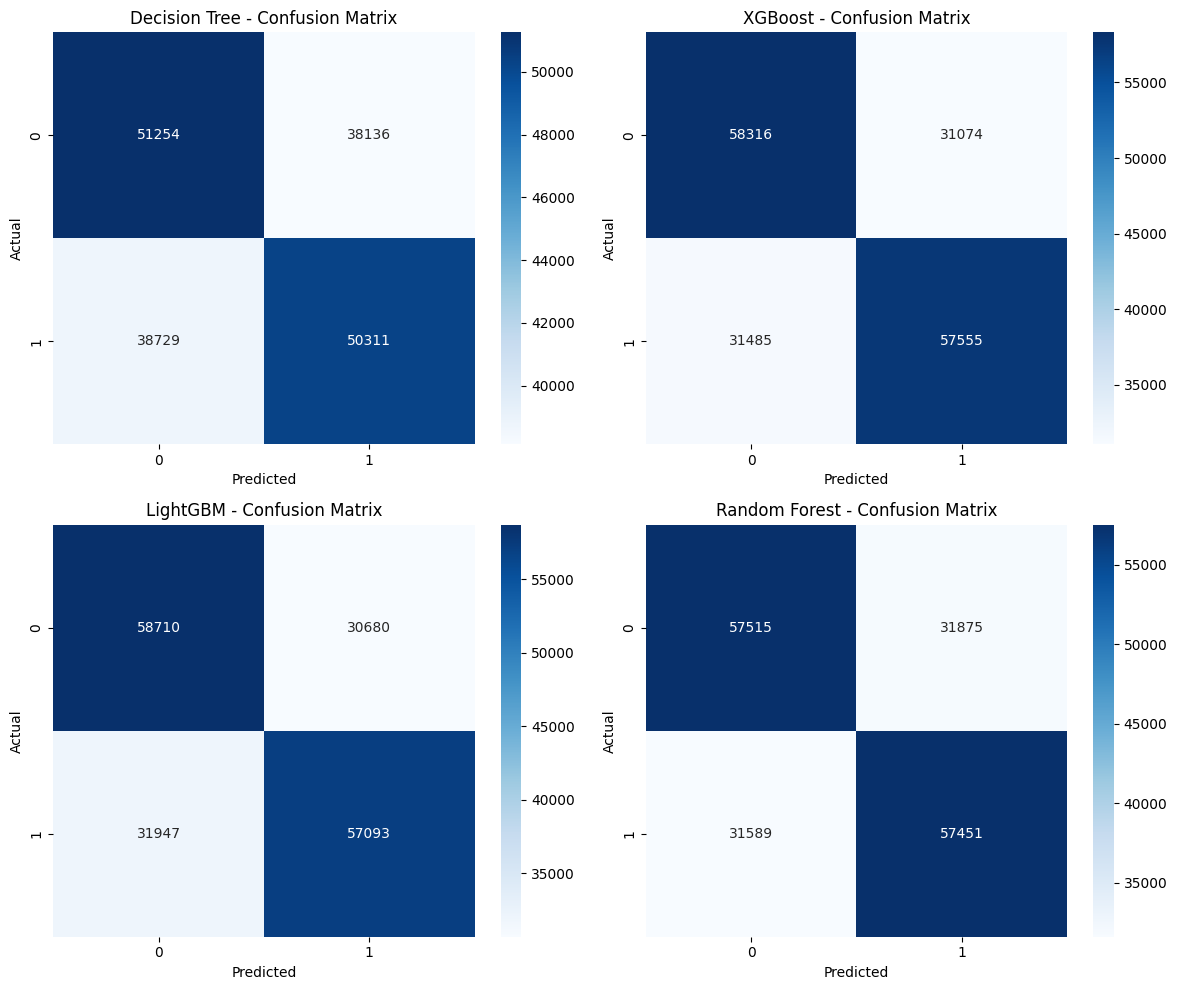

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = [
    ("Decision Tree", y_pred_dt),
    ("XGBoost", xgb_pred),
    ("LightGBM", lgb_pred),
    ("Random Forest", rf_pred)
]

for ax, (name, preds) in zip(axes.flatten(), models):
    cm = confusion_matrix(y_val, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


# Final Model Training & Kaggle Submission

In [ ]:
# Retrain XGBoost on ALL available training data (selected features only)
final_xgb = xgb_model  # reuse same hyperparameters

final_xgb.fit(X[selected_features], y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

1. LOAD TEST SET

In [ ]:
test_path = "/content/drive/MyDrive/test.csv"

test_chunks = []
for chunk in pd.read_csv(test_path, chunksize=400000, low_memory=False):
    test_chunks.append(chunk)

test_df = pd.concat(test_chunks, ignore_index=True)
print("Test shape:", test_df.shape)

machine_ids = test_df["MachineIdentifier"]
test_df = test_df.drop(columns=["MachineIdentifier"], errors="ignore")

Test shape: (7853253, 82)


2. APPLY DERIVED FEATURES (same logic as training)

In [ ]:
# RAM per core
if 'Census_TotalPhysicalRAM' in test_df.columns and 'Census_ProcessorCoreCount' in test_df.columns:
    test_df['RAM_per_core'] = (
        test_df['Census_TotalPhysicalRAM'] / test_df['Census_ProcessorCoreCount']
    )
else:
    test_df['RAM_per_core'] = np.nan

# Disk to RAM
if 'Census_PrimaryDiskTotalCapacity' in test_df.columns and 'Census_TotalPhysicalRAM' in test_df.columns:
    test_df['disk_to_ram_ratio'] = (
        test_df['Census_PrimaryDiskTotalCapacity'] /
        test_df['Census_TotalPhysicalRAM']
    )
else:
    test_df['disk_to_ram_ratio'] = np.nan

# OSBuild age
if 'OsBuild' in test_df.columns:
    test_df['OSBuild_age'] = test_df['OsBuild'].max() - test_df['OsBuild']
else:
    test_df['OSBuild_age'] = np.nan

# EngineVersion major
if 'EngineVersion' in test_df.columns:
    test_df['EngineVersion_major'] = (
        test_df['EngineVersion'].astype(str)
        .str.split(pat='.', n=1, expand=False)
        .str[0]
    )
else:
    test_df['EngineVersion_major'] = "Missing"


IMPUTATION (same rules as training)

In [ ]:
for col in num_cols:
    if col not in test_df.columns:
        test_df[col] = np.nan

test_df[num_cols] = test_df[num_cols].fillna(X[num_cols].median())

# Ensure all expected categorical columns exist
for col in cat_cols:
    if col not in test_df.columns:
        test_df[col] = "Missing"

test_df[cat_cols] = test_df[cat_cols].fillna("Missing")

4. APPLY TRAINED LABEL ENCODERS



In [ ]:
for col in cat_cols:
    le = label_encoders[col]

    # Add "Missing" if needed
    if "Missing" not in le.classes_:
        le.classes_ = np.append(le.classes_, "Missing")

    # Vectorized convert → string
    col_vals = test_df[col].astype(str)

    # Mark unseen categories
    unseen_mask = ~col_vals.isin(le.classes_)
    col_vals[unseen_mask] = "Missing"

    # Encode
    test_df[col] = le.transform(col_vals)

5. ALIGN FEATURES WITH TRAINING SET

In [ ]:
for col in selected_features:
    if col not in test_df.columns:
        test_df[col] = 0

X_test_final = test_df[selected_features]

6. TRAIN FINAL MODEL ON ALL TRAINING DATA

In [ ]:
final_xgb = XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.5,
    tree_method="hist",
    eval_metric="logloss",
    random_state=42
)

final_xgb.fit(X[selected_features], y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
test_preds = final_xgb.predict_proba(X_test_final)[:, 1]

submission = pd.DataFrame({
    "MachineIdentifier": machine_ids,
    "HasDetections": test_preds
})

submission_path = "/content/drive/MyDrive/submission.csv"
submission.to_csv(submission_path, index=False)

print("Submission file saved to:", submission_path)


Submission file saved to: /content/drive/MyDrive/submission.csv


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>